In [43]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
from sklearn import preprocessing

In [7]:
full_results = pd.read_csv('full_results.csv')
full_stats = pd.read_csv('FullKenPom_pt.csv')

print(full_results.shape)
print(full_stats.shape)
#full_stats

(1112, 11)
(1129, 27)


In [89]:
###mask test and train data###
res_test_mask = (full_results['Year'] == 2016) | (full_results['Year'] == 2017) | (full_results['Year'] == 2018)
stats_test_mask = (full_stats['Season'] == 2016) | (full_stats['Season'] == 2017) | (full_stats['Season'] == 2018)
res_train_mask = (full_results['Year'] < 2016)
stats_train_mask = (full_stats['Season'] < 2016)

res_data_test = full_results[res_test_mask]
stats_data_test = full_stats[stats_test_mask]
res_data_train = full_results[res_train_mask]
stats_data_train = full_stats[stats_train_mask]

#reindex all of them
res_data_test = res_data_test.reset_index()
stats_data_test = stats_data_test.reset_index()
res_data_train = res_data_train.reset_index()
stats_data_train = stats_data_train.reset_index()

for i in range(len(res_data_test)):
    if res_data_test['Region Name'][i] == "First Four":
        res_data_test = res_data_test.drop(i)
for i in range(len(res_data_train)):
    if res_data_train['Region Name'][i] == "First Four":
        res_data_train = res_data_train.drop(i)
        
#reindex all of them
res_data_test = res_data_test.reset_index()
stats_data_test = stats_data_test.reset_index()
res_data_train = res_data_train.reset_index()
stats_data_train = stats_data_train.reset_index()

res_data_train.head(10)

#res_data_test.tail()
#stats_data_test.tail()
#res_data_train.tail()
#stats_data_train.tail()
#data_test

,level_0,index,Unnamed: 0,Year,Round,Region Number,Region Name,SeedA,ScoreA,TeamA,TeamB,ScoreB,SeedB
0,1,1,1,2002,1,1,South,1,84,Duke,Winthrop,37,16
1,2,2,2,2002,1,1,South,2,86,Alabama,Florida Atlantic,78,15
2,3,3,3,2002,1,1,South,3,71,Pittsburgh,Central Connecticut St,54,14
3,4,4,4,2002,1,1,South,4,89,USC,UNC Wilmington,93,13
4,5,5,5,2002,1,1,South,5,75,Indiana,Utah,56,12
5,6,6,6,2002,1,1,South,6,82,California,Pennsylvania,75,11
6,7,7,7,2002,1,1,South,7,61,Oklahoma St,Kent St,69,10
7,8,8,8,2002,1,1,South,8,82,Notre Dame,Charlotte,63,9
8,9,9,9,2002,1,2,West,1,90,Cincinnati,Boston University,52,16
9,10,10,10,2002,1,2,West,2,71,Oklahoma,Illinois Chicago,63,15


In [9]:
#these names match the kenpom stats csv
stats_vec = ["AdjTempo",
            "AdjOE",
            "AdjDE",
            "AdjEM",
            "seed",
            "ConfTournament",
            "SOSAdjEM",
            "NCSOSAdjEM",
            "O-D_eFG_Pct",
            "D-O_TO_Pct",
            "O-D_OR_Pct",
            "O-D_FT_Rate",
            "LastTenRecord"]

print(len(stats_vec))

13


In [10]:
# Move training data into 2 numpy arrays - data and labels (results)
N = len(res_data_train)

training_data = np.zeros((N,13))
training_labels = np.zeros((N,1))

for i in range(len(res_data_train)):
    year = res_data_train['Year'][i]
    teamA = res_data_train['TeamA'][i]
    teamB = res_data_train['TeamB'][i]
    score_diff = res_data_train['ScoreA'][i] - res_data_train['ScoreB'][i]
    for k in range(len(stats_data_train)):
        if ((stats_data_train['Season'][k] == year) and (stats_data_train['TeamName'][k] == teamA)):
            indexA = k
            break
            
    for k in range(len(stats_data_train)):
        if ((stats_data_train['Season'][k] == year) and (stats_data_train['TeamName'][k] == teamB)):
            indexB = k
            break
    for s in range(len(stats_vec)):
        stat = stats_vec[s]
        training_data[i][s] = stats_data_train[stat][indexA] - stats_data_train[stat][indexB]
    
    if (score_diff > 0):
        training_labels[i][0] = 1
    else:
        training_labels[i][0] = 0


In [11]:
# Move testing data into 2 numpy arrays - data and labels (results)
N = len(res_data_test)

testing_data = np.zeros((N,13))
testing_labels = np.zeros((N,1))

for i in range(len(res_data_test)):
#for i in range(5):
    year = res_data_test['Year'][i]
    teamA = res_data_test['TeamA'][i]
    teamB = res_data_test['TeamB'][i]
    score_diff = res_data_test['ScoreA'][i] - res_data_test['ScoreB'][i]
    for k in range(len(stats_data_test)):
        if ((stats_data_test['Season'][k] == year) and (stats_data_test['TeamName'][k] == teamA)):
            indexA = k
            break
            
    for k in range(len(stats_data_test)):
        if ((stats_data_test['Season'][k] == year) and (stats_data_test['TeamName'][k] == teamB)):
            indexB = k
            break
    for s in range(len(stats_vec)):
        stat = stats_vec[s]
        testing_data[i][s] = stats_data_test[stat][indexA] - stats_data_test[stat][indexB]
    
    if (score_diff > 0):
        testing_labels[i][0] = 1
    else:
        testing_labels[i][0] = 0


In [12]:
print(training_data.shape)
print(training_labels.shape)
print('\n')
print(testing_data.shape)
print(testing_labels.shape)

(882, 13)
(882, 1)


(189, 13)
(189, 1)


In [13]:
#Time to normalize the data
training_data = preprocessing.normalize(training_data, axis=0, norm='max')
testing_data = preprocessing.normalize(testing_data, axis=0, norm='max')


In [14]:
dtrain = xgb.DMatrix(training_data, label=training_labels,
                     feature_names=stats_vec)
dtest = xgb.DMatrix(testing_data, label=testing_labels,
                    feature_names=stats_vec)


In [21]:
param = {'objective':'multi:softprob'}
param['eval_metric'] = "merror"
param['num_class'] = 2 # 2 classes for a win or loss

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 1000 #looks like it levels off at around 200, optimal around 750
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-merror:0.291005	train-merror:0.15873
[1]	eval-merror:0.285714	train-merror:0.145125
[2]	eval-merror:0.306878	train-merror:0.131519
[3]	eval-merror:0.275132	train-merror:0.12585
[4]	eval-merror:0.269841	train-merror:0.104308
[5]	eval-merror:0.285714	train-merror:0.089569
[6]	eval-merror:0.285714	train-merror:0.075964
[7]	eval-merror:0.280423	train-merror:0.071429
[8]	eval-merror:0.280423	train-merror:0.064626
[9]	eval-merror:0.291005	train-merror:0.056689
[10]	eval-merror:0.280423	train-merror:0.05102
[11]	eval-merror:0.275132	train-merror:0.05102
[12]	eval-merror:0.301587	train-merror:0.038549
[13]	eval-merror:0.280423	train-merror:0.035147
[14]	eval-merror:0.269841	train-merror:0.026077
[15]	eval-merror:0.269841	train-merror:0.026077
[16]	eval-merror:0.26455	train-merror:0.020408
[17]	eval-merror:0.26455	train-merror:0.018141
[18]	eval-merror:0.26455	train-merror:0.017007
[19]	eval-merror:0.26455	train-merror:0.012472
[20]	eval-merror:0.26455	train-merror:0.011338
[21]	eval-m

[194]	eval-merror:0.232804	train-merror:0
[195]	eval-merror:0.232804	train-merror:0
[196]	eval-merror:0.232804	train-merror:0
[197]	eval-merror:0.238095	train-merror:0
[198]	eval-merror:0.232804	train-merror:0
[199]	eval-merror:0.232804	train-merror:0
[200]	eval-merror:0.232804	train-merror:0
[201]	eval-merror:0.232804	train-merror:0
[202]	eval-merror:0.232804	train-merror:0
[203]	eval-merror:0.232804	train-merror:0
[204]	eval-merror:0.232804	train-merror:0
[205]	eval-merror:0.232804	train-merror:0
[206]	eval-merror:0.232804	train-merror:0
[207]	eval-merror:0.232804	train-merror:0
[208]	eval-merror:0.232804	train-merror:0
[209]	eval-merror:0.232804	train-merror:0
[210]	eval-merror:0.232804	train-merror:0
[211]	eval-merror:0.232804	train-merror:0
[212]	eval-merror:0.232804	train-merror:0
[213]	eval-merror:0.232804	train-merror:0
[214]	eval-merror:0.232804	train-merror:0
[215]	eval-merror:0.238095	train-merror:0
[216]	eval-merror:0.238095	train-merror:0
[217]	eval-merror:0.238095	train-m

[390]	eval-merror:0.232804	train-merror:0
[391]	eval-merror:0.232804	train-merror:0
[392]	eval-merror:0.227513	train-merror:0
[393]	eval-merror:0.227513	train-merror:0
[394]	eval-merror:0.227513	train-merror:0
[395]	eval-merror:0.227513	train-merror:0
[396]	eval-merror:0.227513	train-merror:0
[397]	eval-merror:0.227513	train-merror:0
[398]	eval-merror:0.227513	train-merror:0
[399]	eval-merror:0.227513	train-merror:0
[400]	eval-merror:0.227513	train-merror:0
[401]	eval-merror:0.227513	train-merror:0
[402]	eval-merror:0.227513	train-merror:0
[403]	eval-merror:0.227513	train-merror:0
[404]	eval-merror:0.227513	train-merror:0
[405]	eval-merror:0.227513	train-merror:0
[406]	eval-merror:0.227513	train-merror:0
[407]	eval-merror:0.227513	train-merror:0
[408]	eval-merror:0.227513	train-merror:0
[409]	eval-merror:0.227513	train-merror:0
[410]	eval-merror:0.227513	train-merror:0
[411]	eval-merror:0.227513	train-merror:0
[412]	eval-merror:0.227513	train-merror:0
[413]	eval-merror:0.227513	train-m

[586]	eval-merror:0.227513	train-merror:0
[587]	eval-merror:0.227513	train-merror:0
[588]	eval-merror:0.227513	train-merror:0
[589]	eval-merror:0.227513	train-merror:0
[590]	eval-merror:0.227513	train-merror:0
[591]	eval-merror:0.227513	train-merror:0
[592]	eval-merror:0.227513	train-merror:0
[593]	eval-merror:0.227513	train-merror:0
[594]	eval-merror:0.227513	train-merror:0
[595]	eval-merror:0.227513	train-merror:0
[596]	eval-merror:0.227513	train-merror:0
[597]	eval-merror:0.227513	train-merror:0
[598]	eval-merror:0.227513	train-merror:0
[599]	eval-merror:0.227513	train-merror:0
[600]	eval-merror:0.227513	train-merror:0
[601]	eval-merror:0.227513	train-merror:0
[602]	eval-merror:0.227513	train-merror:0
[603]	eval-merror:0.227513	train-merror:0
[604]	eval-merror:0.227513	train-merror:0
[605]	eval-merror:0.227513	train-merror:0
[606]	eval-merror:0.227513	train-merror:0
[607]	eval-merror:0.227513	train-merror:0
[608]	eval-merror:0.227513	train-merror:0
[609]	eval-merror:0.227513	train-m

[782]	eval-merror:0.222222	train-merror:0
[783]	eval-merror:0.222222	train-merror:0
[784]	eval-merror:0.222222	train-merror:0
[785]	eval-merror:0.222222	train-merror:0
[786]	eval-merror:0.222222	train-merror:0
[787]	eval-merror:0.222222	train-merror:0
[788]	eval-merror:0.222222	train-merror:0
[789]	eval-merror:0.222222	train-merror:0
[790]	eval-merror:0.222222	train-merror:0
[791]	eval-merror:0.222222	train-merror:0
[792]	eval-merror:0.222222	train-merror:0
[793]	eval-merror:0.222222	train-merror:0
[794]	eval-merror:0.222222	train-merror:0
[795]	eval-merror:0.222222	train-merror:0
[796]	eval-merror:0.222222	train-merror:0
[797]	eval-merror:0.222222	train-merror:0
[798]	eval-merror:0.222222	train-merror:0
[799]	eval-merror:0.222222	train-merror:0
[800]	eval-merror:0.222222	train-merror:0
[801]	eval-merror:0.222222	train-merror:0
[802]	eval-merror:0.222222	train-merror:0
[803]	eval-merror:0.222222	train-merror:0
[804]	eval-merror:0.222222	train-merror:0
[805]	eval-merror:0.222222	train-m

[978]	eval-merror:0.222222	train-merror:0
[979]	eval-merror:0.222222	train-merror:0
[980]	eval-merror:0.222222	train-merror:0
[981]	eval-merror:0.222222	train-merror:0
[982]	eval-merror:0.222222	train-merror:0
[983]	eval-merror:0.222222	train-merror:0
[984]	eval-merror:0.222222	train-merror:0
[985]	eval-merror:0.222222	train-merror:0
[986]	eval-merror:0.222222	train-merror:0
[987]	eval-merror:0.222222	train-merror:0
[988]	eval-merror:0.222222	train-merror:0
[989]	eval-merror:0.222222	train-merror:0
[990]	eval-merror:0.222222	train-merror:0
[991]	eval-merror:0.222222	train-merror:0
[992]	eval-merror:0.222222	train-merror:0
[993]	eval-merror:0.222222	train-merror:0
[994]	eval-merror:0.222222	train-merror:0
[995]	eval-merror:0.222222	train-merror:0
[996]	eval-merror:0.222222	train-merror:0
[997]	eval-merror:0.222222	train-merror:0
[998]	eval-merror:0.222222	train-merror:0
[999]	eval-merror:0.222222	train-merror:0


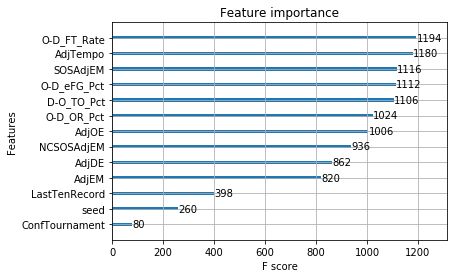

In [22]:
### Shows the weight of each stat vector ###
xgb.plot_importance(bst)

In [40]:
outcome = bst.predict(dtest)
#outcome = outcome*100 #Converting to percentage
outcome

array([[1.39326323e-04, 9.99860644e-01],
       [1.51827862e-05, 9.99984860e-01],
       [1.07778702e-03, 9.98922229e-01],
       [7.60570765e-02, 9.23942924e-01],
       [2.15521201e-01, 7.84478843e-01],
       [2.41975486e-01, 7.58024454e-01],
       [2.38437839e-02, 9.76156175e-01],
       [9.99553144e-01, 4.46857506e-04],
       [1.28361380e-05, 9.99987125e-01],
       [1.22584682e-02, 9.87741470e-01],
       [4.72467422e-04, 9.99527574e-01],
       [4.80326824e-03, 9.95196760e-01],
       [2.78532021e-02, 9.72146809e-01],
       [2.86054254e-01, 7.13945687e-01],
       [8.93506110e-02, 9.10649359e-01],
       [9.60729301e-01, 3.92706767e-02],
       [9.78055323e-06, 9.99990225e-01],
       [3.47355763e-06, 9.99996543e-01],
       [8.28025863e-04, 9.99171972e-01],
       [3.94835282e-04, 9.99605238e-01],
       [5.63103147e-03, 9.94368970e-01],
       [3.74912977e-01, 6.25087023e-01],
       [9.13577899e-02, 9.08642173e-01],
       [8.57902169e-01, 1.42097771e-01],
       [9.867423

In [87]:
correct_list = np.zeros_like(testing_labels)
for i in range(len(outcome)):
    if outcome[i][1] > outcome[i][0]:
        if random.random() < outcome[i][1]:
            metric = 1 # team A favored to win
        else:
            metric = 0 # Upset pushed by random chance
    else:
        if random.random() < outcome[i][0]:
            metric = 0 # team B favored to win
        else:
            metric = 1 # team A wins as underdog
    correct_list[i][0] = metric
print("% Correct:", (correct_list.sum() / len(correct_list))*100)

% Correct: 79.8941798941799


[9.9955315e+01 4.4685751e-02]
[0.]
